In [ ]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

100%|██████████| 225M/225M [00:18<00:00, 12.5MB/s] 

Extracting files...


Path to dataset files: C:\Users\trh00\.cache\kagglehub\datasets\alxmamaev\flowers-recognition\versions\2


In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import random
import os

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

# Load dataset
dataset_path = r"C:\Users\trh00\.cache\kagglehub\datasets\alxmamaev\flowers-recognition\versions\2\flowers"  
dataset = ImageFolder(root=dataset_path, transform=transform)

In [19]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [16]:
# Split dataset into train and test
random.seed(42)
indices = list(range(len(dataset)))
random.shuffle(indices)
split = int(len(dataset) * 0.8)
train_indices, test_indices = indices[:split], indices[split:]
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [17]:
# quick check if the data is loaded correctly
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [40]:
import torch
import torch.nn as nn
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Activation
        self.relu = nn.ReLU()
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128,5 )  # 10 output classes for CIFAR-10

    def forward(self, x):
        # original shape 1, 250, 90
        # Convolution + ReLU + Pooling
        x = self.pool(self.relu(self.conv1(x)))  # 122 122
        x = self.pool(self.relu(self.conv2(x)))  #  61 61 
        x = self.pool(self.relu(self.conv3(x)))  #      30 30 
        
        # Flatten
        x = x.view(x.size(0), -1)  # (Batch, 64*4*4)
        
        # Fully Connected Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Logits
        
        return x                # Although this is a classification problem, we didn't apply softmax. Do you know why?👀 (Hint: CrossEntropyLoss has something to do here👀)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)


In [41]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


In [42]:
import torch.optim as optim

# Initialize the model

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 108/108 [00:48<00:00,  2.22it/s]


Epoch 1/10: Train Loss=1.3598, Train Accuracy=40.40%, Val Loss=1.1944, Val Accuracy=46.53%


100%|██████████| 108/108 [00:48<00:00,  2.24it/s]


Epoch 2/10: Train Loss=1.0748, Train Accuracy=55.46%, Val Loss=1.0135, Val Accuracy=58.91%


100%|██████████| 108/108 [00:39<00:00,  2.71it/s]


Epoch 3/10: Train Loss=0.9401, Train Accuracy=63.83%, Val Loss=0.9746, Val Accuracy=60.76%


100%|██████████| 108/108 [00:57<00:00,  1.88it/s]


Epoch 4/10: Train Loss=0.8015, Train Accuracy=69.74%, Val Loss=0.8913, Val Accuracy=63.31%


100%|██████████| 108/108 [01:01<00:00,  1.76it/s]


Epoch 5/10: Train Loss=0.6861, Train Accuracy=73.82%, Val Loss=0.9119, Val Accuracy=66.44%


100%|██████████| 108/108 [00:54<00:00,  1.98it/s]


Epoch 6/10: Train Loss=0.4933, Train Accuracy=82.07%, Val Loss=0.9799, Val Accuracy=63.89%


100%|██████████| 108/108 [00:57<00:00,  1.86it/s]


Epoch 7/10: Train Loss=0.2802, Train Accuracy=90.56%, Val Loss=1.2734, Val Accuracy=64.93%


100%|██████████| 108/108 [00:37<00:00,  2.87it/s]


Epoch 8/10: Train Loss=0.1514, Train Accuracy=95.28%, Val Loss=1.6052, Val Accuracy=61.92%


100%|██████████| 108/108 [00:38<00:00,  2.84it/s]


Epoch 9/10: Train Loss=0.1069, Train Accuracy=96.61%, Val Loss=1.7482, Val Accuracy=64.12%


100%|██████████| 108/108 [00:37<00:00,  2.87it/s]


Epoch 10/10: Train Loss=0.0523, Train Accuracy=98.61%, Val Loss=1.6897, Val Accuracy=65.74%


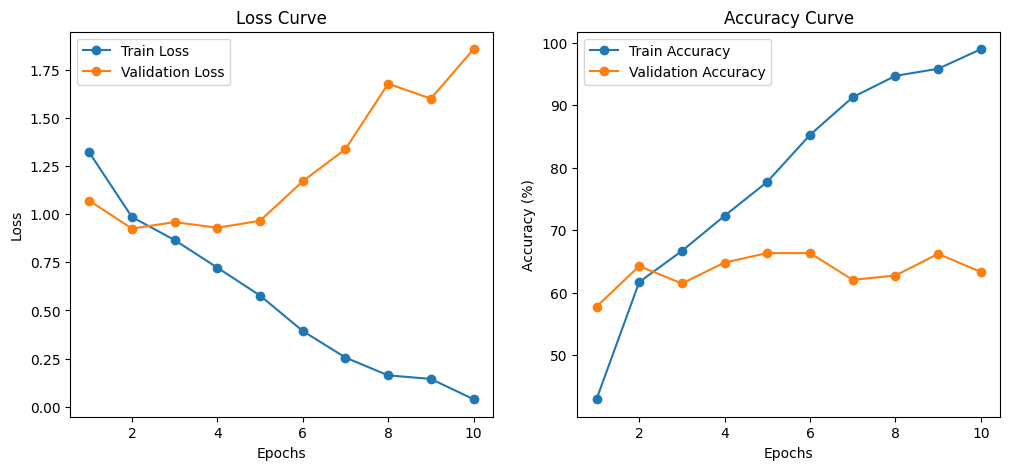

In [35]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [39]:
print(len(train_dataset))

3453
